构建图像可视化函数，将3个时间段的Maxigauge, cooling, temperature共9个时间序列文档依次呈现

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def data_vis(df):
    df['datetime'] = pd.to_datetime(df['datetime'])  # transform the time format
    df = df.sort_values("datetime")  # rank according to the time series

    # load all the sensor channels
    channels = df['channel'].unique()

    # set the font size
    plt.rcParams.update({'font.size': 5})  

    # set the figure size
    fig, axes = plt.subplots(nrows=len(channels), ncols=1, figsize=(6, len(channels) * 1.5), sharex=True)

    if len(channels) == 1:
        axes = [axes]

    # Traverse each channel, drawing the separate subgraph
    for i, channel in enumerate(channels):
        sub_df = df[df['channel'] == channel]  # select the data for a specific channel
        axes[i].plot(sub_df['datetime'], sub_df['value'], label=f"Channel {channel}", color='b')

        # set time format
        axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=12)) # every 12hs
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # time format

        # Get all scales for the current X-axis
        tick_labels = [label.get_text() for label in axes[i].get_xticklabels()]
    
        # Keep only part of the label, 1 out of every 4 labels
        for j, label in enumerate(axes[i].get_xticklabels()):
            if j % 4 != 0: 
                label.set_visible(False)

        axes[i].set_ylabel("Value")
        axes[i].set_title(f"Time Series for Channel {channel}")
        axes[i].legend()
        axes[i].grid(True)

    # Format the X-axis
    plt.xlabel("Time")
    plt.xticks(rotation=15)  # Rotate the X-axis scale to prevent overlap
    plt.tight_layout()
    plt.show()


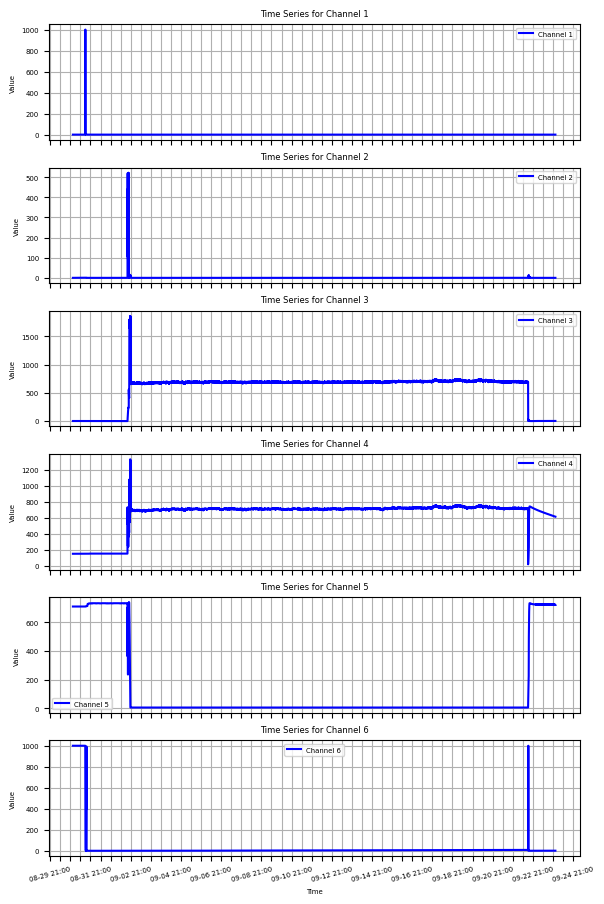

In [61]:
from data_visualization import data_vis
import pandas as pd

df = pd.read_csv("databases/data_csv/cd230831/maxigauge.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

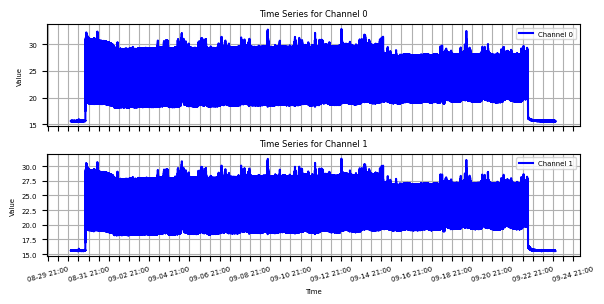

In [62]:
df = pd.read_csv("databases/data_csv/cd230831/cooling.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

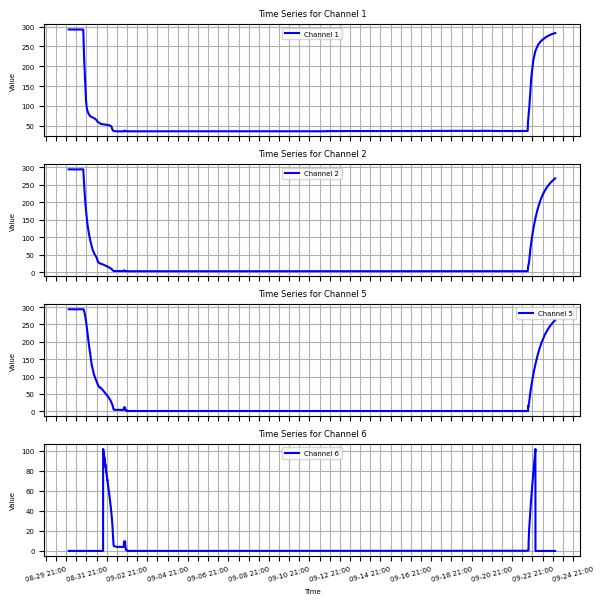

In [63]:
df = pd.read_csv("databases/data_csv/cd230831/temperature.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

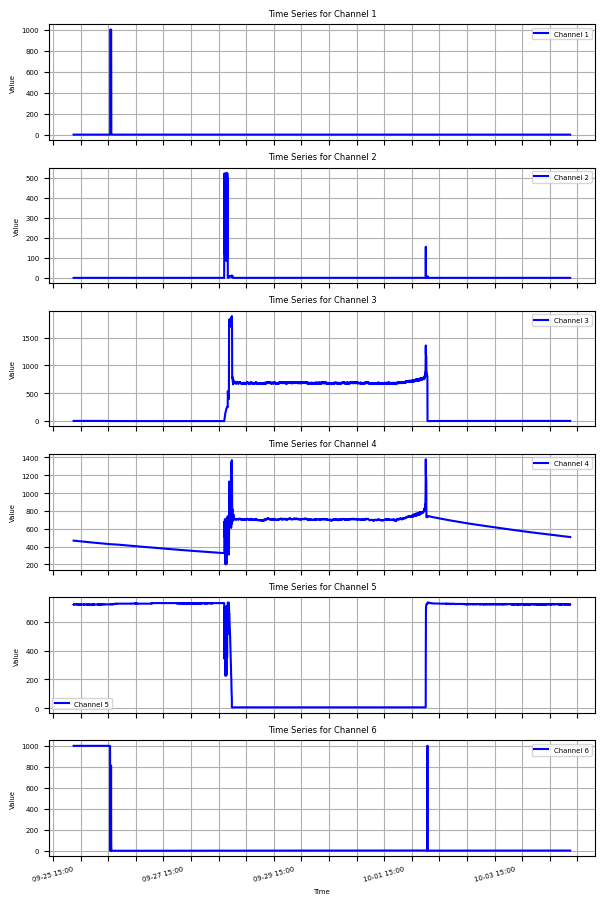

In [64]:
df = pd.read_csv("databases/data_csv/cd230926/maxigauge.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

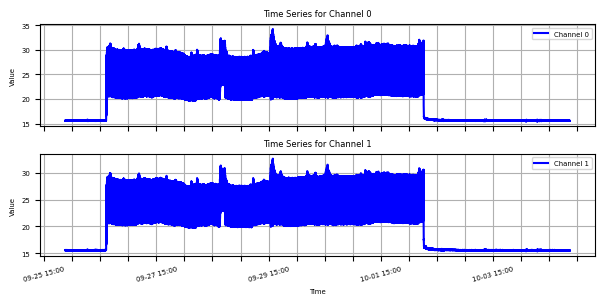

In [65]:
df = pd.read_csv("databases/data_csv/cd230926/cooling.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

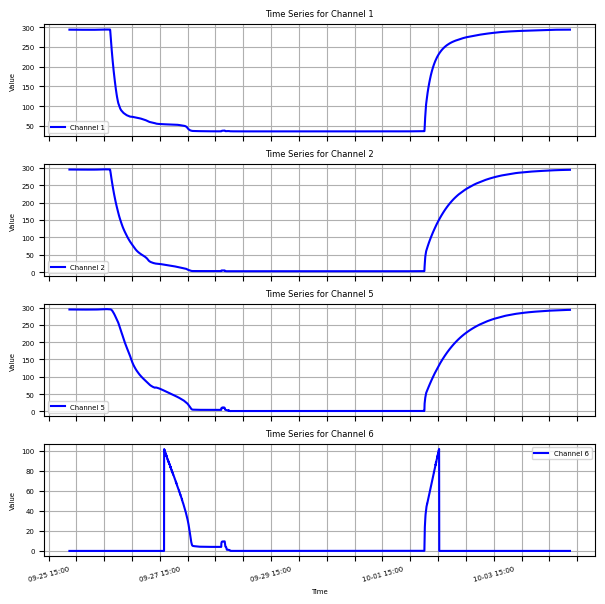

In [66]:
df = pd.read_csv("databases/data_csv/cd230926/temperature.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

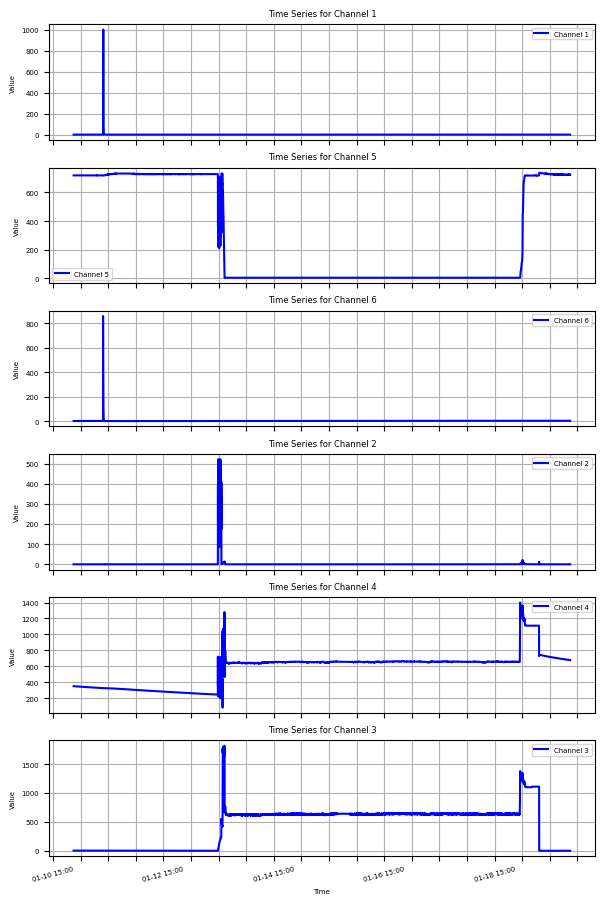

In [67]:
df = pd.read_csv("databases/data_csv/cd240111/maxigauge.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

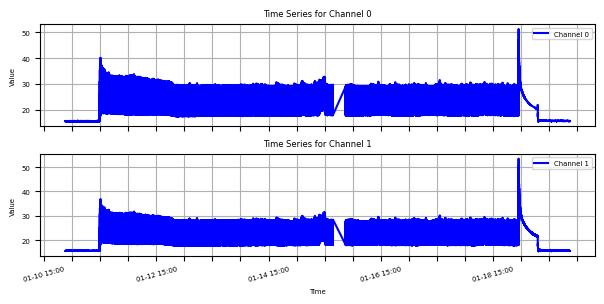

In [68]:
df = pd.read_csv("databases/data_csv/cd240111/cooling.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

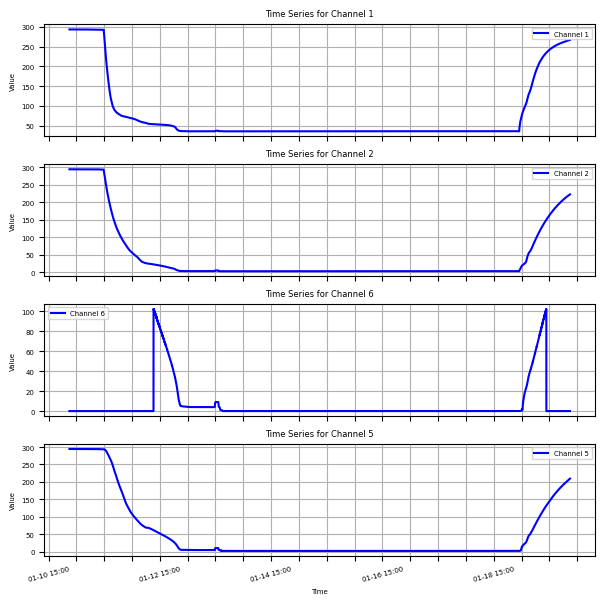

In [69]:
df = pd.read_csv("databases/data_csv/cd240111/temperature.csv")  # or maxigauge.csv / cooling.csv
data_vis(df)

构建插值函数，确保每30秒一个时间戳，为了后续对齐，每个时间戳落在整分钟或者半分钟（XX:XX:00 or XX:XX:30）,选取第一项数据的前面一个整分钟或者半分钟作为起点。
1. 处理 datetime 字段，确保格式正确，并设置为索引
2. 如果存在 io 列，更新 channel 编码
3. 将 channel 作为列 (pivot)，并填充缺失值
4. 重新对齐时间序列，每 30 秒一个数据点
5. 进行线性插值，确保数据完整

In [70]:
import pandas as pd
import numpy as np

def data_interpolate(df: pd.DataFrame) -> pd.DataFrame:

    # 确保 datetime 是正确格式并设置索引
    if "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S.%f")
        df = df.set_index("datetime")

    # 处理 io 列（如果存在）
    if "io" in df.columns:
        df["channel"] = df.apply(lambda row: 0 if (row["channel"] == 0 and row["io"] == 0) else
                                            1 if (row["channel"] == 0 and row["io"] == 1) else
                                           10 if (row["channel"] == 1 and row["io"] == 0) else
                                           11, axis=1)
        df = df[["channel", "value"]]  # 只保留所需的列

    # 使用 pivot_table 让 channel 变为列
    df_pivot = df.pivot_table(index=df.index, columns="channel", values="value")

    # 重命名列名为 "channelX"
    df_pivot.columns = [f"channel{int(col)}" for col in df_pivot.columns]

    # 计算标准化的 30 秒时间戳
    start_time = df.index.min().floor("30S")  # 向下取整到 00s 或 30s
    end_time = df.index.max().ceil("30S")  # 向上取整到 00s 或 30s
    new_time_stamps = pd.date_range(start=start_time, end=end_time, freq="30S")

    # 创建新 DataFrame，并进行插值
    new_df = pd.DataFrame({"datetime": new_time_stamps})

    # 转换时间戳为整数以进行插值
    new_df["timestamp"] = new_df["datetime"].astype('int64') // 10**9
    df_pivot["timestamp"] = df_pivot.index.astype('int64') // 10**9

    # 对每个 channel 进行线性插值
    for col in df_pivot.columns:
        if col != "timestamp":  # 避免 timestamp 列被修改
            new_df[col] = np.interp(new_df["timestamp"], df_pivot["timestamp"], df_pivot[col])

    #移除 timestamp，设置 datetime 为索引
    new_df = new_df.drop(columns=["timestamp"]).set_index("datetime")

    return new_df


遍历文件夹，将同时间段的所有数据合成一个csv文件

In [71]:
import pandas as pd
import os

folder_path = "databases/data_csv/cd230831"

# 获取所有 CSV 文件
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# 读取并合并 CSV
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)  # 读取 CSV
    df=data_interpolate(df)
    if file.endswith('cooling.csv'):
        df = df.add_prefix("cooling_")
    elif file.endswith('maxigauge.csv'):
        df = df.add_prefix("maxigauge_")
    elif file.endswith('temperature.csv'):
        df = df.add_prefix("temperature_")
    df_list.append(df)

#df_list[0].to_csv("1.csv", index=True)
#df_list[1].to_csv("2.csv", index=True)
#df_list[2].to_csv("3.csv", index=True)

df_merged = pd.concat(df_list, axis=1, join="outer")  # 按索引对齐

output_folder = "databases/processed_data"

# 如果文件夹不存在，则创建它
os.makedirs(output_folder, exist_ok=True)

# 定义 CSV 文件路径
output_file = os.path.join(output_folder, "cd230831.csv")

# 将 DataFrame 存储为 CSV
df_merged.to_csv(output_file, index=True)



C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start_time = df.index.min().floor("30S")  # 向下取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  end_time = df.index.max().ceil("30S")  # 向上取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_time_stamps = pd.date_range(start=start_time, end=end_time, freq="30S")
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start_time = df.index.min().floor("30S")  # 向下取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:27: FutureWarnin

In [72]:
import pandas as pd
import os

folder_path = "databases/data_csv/cd230926"

# 获取所有 CSV 文件
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# 读取并合并 CSV
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)  # 读取 CSV
    df=data_interpolate(df)
    if file.endswith('cooling.csv'):
        df = df.add_prefix("cooling_")
    elif file.endswith('maxigauge.csv'):
        df = df.add_prefix("maxigauge_")
    elif file.endswith('temperature.csv'):
        df = df.add_prefix("temperature_")
    df_list.append(df)

#df_list[0].to_csv("1.csv", index=True)
#df_list[1].to_csv("2.csv", index=True)
#df_list[2].to_csv("3.csv", index=True)

df_merged = pd.concat(df_list, axis=1, join="outer")  # 按索引对齐

output_folder = "databases/processed_data"

# 如果文件夹不存在，则创建它
os.makedirs(output_folder, exist_ok=True)

# 定义 CSV 文件路径
output_file = os.path.join(output_folder, "cd230926.csv")

# 将 DataFrame 存储为 CSV
df_merged.to_csv(output_file, index=True)



C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start_time = df.index.min().floor("30S")  # 向下取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  end_time = df.index.max().ceil("30S")  # 向上取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_time_stamps = pd.date_range(start=start_time, end=end_time, freq="30S")
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start_time = df.index.min().floor("30S")  # 向下取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:27: FutureWarnin

In [73]:
import pandas as pd
import os

folder_path = "databases/data_csv/cd240111"

# 获取所有 CSV 文件
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# 读取并合并 CSV
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)  # 读取 CSV
    df=data_interpolate(df)
    if file.endswith('cooling.csv'):
        df = df.add_prefix("cooling_")
    elif file.endswith('maxigauge.csv'):
        df = df.add_prefix("maxigauge_")
    elif file.endswith('temperature.csv'):
        df = df.add_prefix("temperature_")
    df_list.append(df)

#df_list[0].to_csv("1.csv", index=True)
#df_list[1].to_csv("2.csv", index=True)
#df_list[2].to_csv("3.csv", index=True)

df_merged = pd.concat(df_list, axis=1, join="outer")  # 按索引对齐

output_folder = "databases/processed_data"

# 如果文件夹不存在，则创建它
os.makedirs(output_folder, exist_ok=True)

# 定义 CSV 文件路径
output_file = os.path.join(output_folder, "cd240111.csv")

# 将 DataFrame 存储为 CSV
df_merged.to_csv(output_file, index=True)



C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start_time = df.index.min().floor("30S")  # 向下取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  end_time = df.index.max().ceil("30S")  # 向上取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  new_time_stamps = pd.date_range(start=start_time, end=end_time, freq="30S")
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  start_time = df.index.min().floor("30S")  # 向下取整到 00s 或 30s
C:\Users\Gerry\AppData\Local\Temp\ipykernel_3232\1006700298.py:27: FutureWarnin

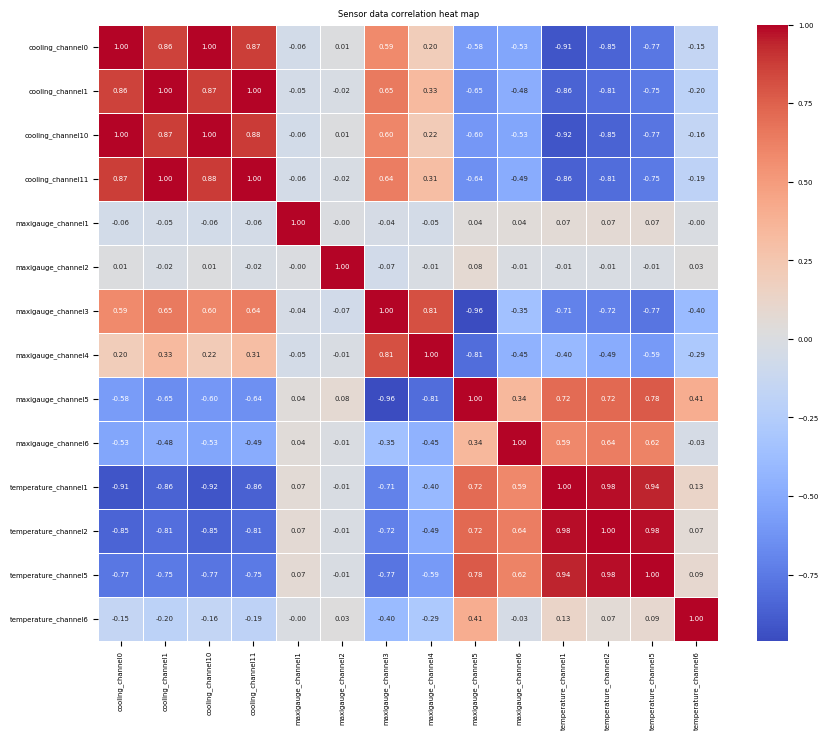

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSV 数据
file_path = "databases/processed_data/cd230831.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)  # 以时间为索引

# 计算相关性矩阵
correlation_matrix = df.corr(method="pearson")

# 相关性矩阵
# print("correlation matrix:")
# print(correlation_matrix)

# 热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Sensor data correlation heat map")
plt.show()


将三个时间段的csv文件合并成一个完整的csv文件，涵盖所有传感器通道在三个时间段的插值对齐后的数据，随后进行每个通道间的相关性计算

CSV1 shape: (69112, 14)
CSV2 shape: (25911, 14)
CSV3 shape: (25909, 14)


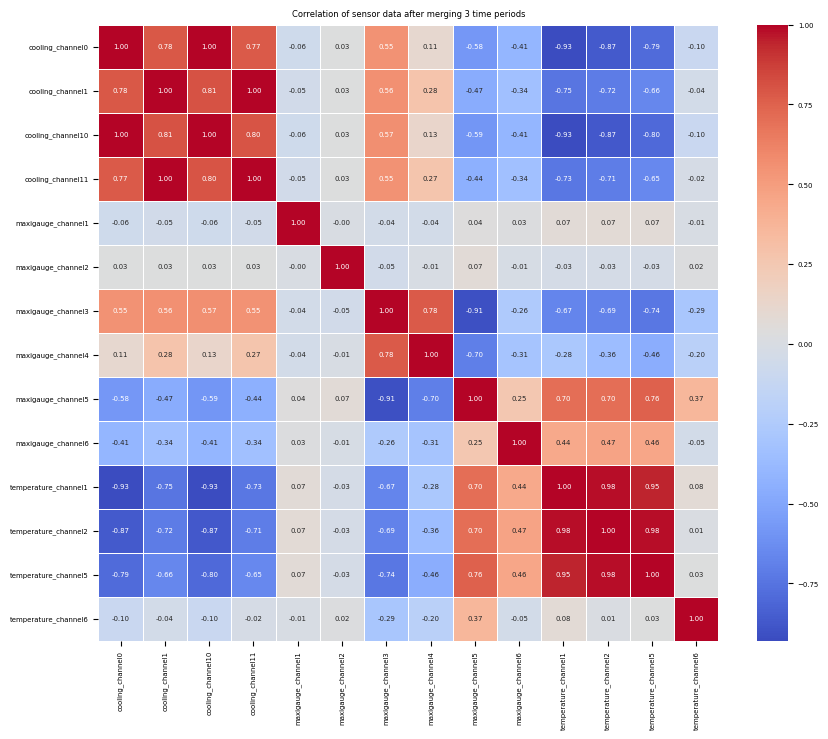

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Step 1: 读取 3 个 CSV 文件**
file_1 = "databases/processed_data/cd230831.csv"
file_2 = "databases/processed_data/cd230926.csv"
file_3 = "databases/processed_data/cd240111.csv"

df1 = pd.read_csv(file_1, index_col=0, parse_dates=True)
df2 = pd.read_csv(file_2, index_col=0, parse_dates=True)
df3 = pd.read_csv(file_3, index_col=0, parse_dates=True)

# **Step 2: 确保 3 个数据格式一致
print("CSV1 shape:", df1.shape)
print("CSV2 shape:", df2.shape)
print("CSV3 shape:", df3.shape)

# **Step 3: 合并数据（按 `datetime` 对齐
df_all = pd.concat([df1, df2, df3], axis=0)  # 纵向合并
df_all = df_all.sort_index()  # 按时间排序

df_all.to_csv('databases/processed_data/all.csv', index=True)

# **Step 4: 计算相关性矩阵
corr_matrix = df_all.corr(method="pearson")

# **Step 5: 绘制相关性热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of sensor data after merging 3 time periods")
plt.show()


生成每个传感器channel的数据描述性统计表

In [76]:
import pandas as pd

# 读取 CSV 文件
file_path = "databases/processed_data/all.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# 计算每个 Channel 的统计信息
stats = df.describe()

# 显示统计信息
print(stats)

stats.to_csv('databases/processed_data/correlation.csv', index=True)




       cooling_channel0  cooling_channel1  cooling_channel10  \
count     120930.000000     120930.000000      120930.000000   
mean          27.230448         18.529658          26.200818   
std            5.120091          1.556749           4.685760   
min           15.398997         15.396052          15.362593   
25%           28.037128         17.982864          27.025355   
50%           29.221222         18.705858          27.962707   
75%           29.698843         19.343666          28.451849   
max           50.961763         29.299443          53.326947   

       cooling_channel11  maxigauge_channel1  maxigauge_channel2  \
count      120930.000000       120925.000000       120925.000000   
mean           18.604432            0.724903            1.349305   
std             1.603867           25.771203           20.269836   
min            15.414538            0.000004            0.000501   
25%            18.115915            0.000005            0.022200   
50%            